## Course Code: DS4003
## Course Name: Principles and Techniques for Data Science
## Lab Session: 09 - Timeseries Analysis 2


### In this lab, we will look at:
- Deep Learning Models for forecasting
- Timeseries Transformation 
- Timeseries Mining
- Timeseries Clustering

In [45]:
# Basic libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os


# LSTM model for TSA
Read more here: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

### Import PyTorch 

In [46]:
import torch.nn as nn 
import torch
from torch.utils.data import Dataset, DataLoader


### Define a simple LSTM model 

In [47]:
class SimpleLSTM(nn.Module): 
    def __init__(self, num_input=1, hidden_size=512, hidden_layers=2): 
        super().__init__()
        self.num_layers = hidden_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=num_input, hidden_size=hidden_size, num_layers=hidden_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1) 
    
    def forward(self, data): 
        batch_size = data.shape[0]
        h0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).requires_grad_()
        lout, (hn, _) = self.lstm(data, (h0, c0))
        hn = hn[-1]
        out = self.linear(hn).flatten() 
        return out

### Define a dataset class to work with PyTorch 

In [48]:
class SequenceDataset(Dataset):
    def __init__(self, df, target,features,  sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(df[target].values).float()
        self.X = torch.tensor(df[features].values).float()
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i < self.sequence_length: 
            padding = self.X[0].repeat(self.sequence_length - i, 1)
            x = self.X[: i]
            x = torch.cat((padding, x.view(-1, 1)), dim=0)
        else:
            start = i - self.sequence_length 
            x = self.X[start:i].view(-1, 1)
        return x.view(-1,1), self.y[i]

### Read the Air Passenger Dataset

In [49]:
df = pd.read_csv('AirPassengers.csv', header=0)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Now, let's create a new feature by shifting the values in the Passengers column. 
- shift(1) moves the data in #Passengers down by one row, meaning each row in P1 contains the value of #Passengers from the previous row.
- Next, we will calculate the change between columns and compute the rate of change from the previous to the current row. This will be stored in the column Change

In [50]:
df['P1'] = df['#Passengers'].shift(1)
df['Change'] = (df['P1'] - df['#Passengers']) / df['#Passengers']
df.dropna(inplace=True)
df.head()

,#Passengers,P1,Change
Month,,,
1949-02-01,118,112.0,-0.050847
1949-03-01,132,118.0,-0.106061
1949-04-01,129,132.0,0.023256
1949-05-01,121,129.0,0.066116
1949-06-01,135,121.0,-0.103704


### Split the data to train test set 

In [7]:
train_df = df.iloc[:100]
test_df = df.iloc[100:]

### Create Dataset instances of the class we created above 

In [8]:
train_dataset = SequenceDataset(
    train_df,
    target='Change',
    features='Change',
    sequence_length=10
)

In [9]:
test_dataset = SequenceDataset(
    test_df,
    target='Change',
    features='Change',
    sequence_length=10
)

### Create Data Loader 

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Define Trainer for Deep Learning Model 

In [11]:
from tqdm.auto import tqdm 

def train(n_epoch, data_loader, model, loss_function, optimizer):
    pbar = tqdm(total=n_epoch)
    loss_list = list() 
    for epoch in range(n_epoch):
        num_batches = len(data_loader)
        total_loss = 0
        best_loss = np.inf 
        model.train()
        pbar.set_description(f'Epoch: {epoch}')
        for X, y in data_loader:
            output = model(X)
            loss = loss_function(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if loss.item() < best_loss: 
                best_loss = loss.item()
                torch.save(model.state_dict(), 'best_model.pt')
            total_loss += loss.item()
            pbar.set_postfix({'Loss': loss.item()})
        avg_loss = total_loss / num_batches
        pbar.update()
        loss_list.append(avg_loss)
    pbar.close()
    return loss_list 

### Next, we will try to train the LSTM model with out data


### Task: finetune the hyperparameters (play around with them). Were you able to get a good model?

In [12]:
model = SimpleLSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
losses = train(100, train_loader, model, loss_fn, optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

### Visualize the loss curve 

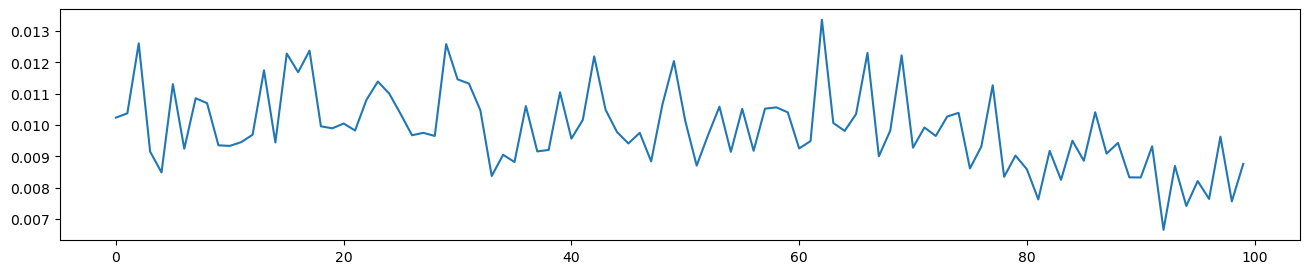

In [13]:
plt.figure(figsize=(16,3))
plt.plot(losses)

### Reload the best model 

In [14]:
model = SimpleLSTM()
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

### Make Prediction 

In [15]:
model.eval() 
pred_list = list()
for X, y in test_loader: 
    output = model(X)
    output = output.detach().cpu().numpy() 
    pred_list.extend(output.tolist())

### Plot the ground truth vs prediction 

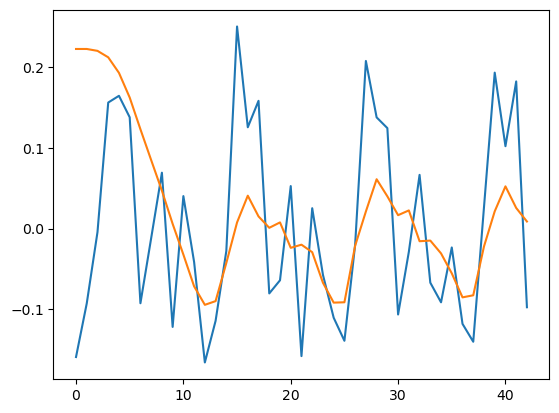

In [16]:
plt.plot(test_df['Change'].values)
plt.plot(np.array(pred_list))

# Facebook Prophet
You can read more about it here https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [17]:
!pip install prophet

In [18]:
from prophet import Prophet

In [19]:
train_df.head()

,#Passengers,P1,Change
Month,,,
1949-02-01,118,112.0,-0.050847
1949-03-01,132,118.0,-0.106061
1949-04-01,129,132.0,0.023256
1949-05-01,121,129.0,0.066116
1949-06-01,135,121.0,-0.103704


In [20]:
pro = Prophet()
pro_df = train_df[["Change"]].copy()
pro_df.reset_index(inplace=True)
pro_df.columns = ['ds', 'y']
pro.fit(pro_df)

11:22:29 - cmdstanpy - INFO - Chain [1] start processing
11:22:29 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future = pro.make_future_dataframe(periods=44, freq="MS")

In [22]:
pred = pro.predict(future)

In [23]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-02-01,-0.006614,-0.048469,0.036613,-0.006614,-0.006614,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.0,0.0,0.0,-0.006082
1,1949-03-01,-0.006576,-0.178458,-0.094715,-0.006576,-0.006576,-0.130807,-0.130807,-0.130807,-0.130807,-0.130807,-0.130807,0.0,0.0,0.0,-0.137383
2,1949-04-01,-0.006534,-0.011508,0.074831,-0.006534,-0.006534,0.036525,0.036525,0.036525,0.036525,0.036525,0.036525,0.0,0.0,0.0,0.029991
3,1949-05-01,-0.006493,-0.037641,0.047998,-0.006493,-0.006493,0.009699,0.009699,0.009699,0.009699,0.009699,0.009699,0.0,0.0,0.0,0.003206
4,1949-06-01,-0.006451,-0.158398,-0.076805,-0.006451,-0.006451,-0.109839,-0.109839,-0.109839,-0.109839,-0.109839,-0.109839,0.0,0.0,0.0,-0.116290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-09-01,-0.001440,0.077001,0.160985,-0.001465,-0.001416,0.121486,0.121486,0.121486,0.121486,0.121486,0.121486,0.0,0.0,0.0,0.120046
140,1960-10-01,-0.001403,0.098826,0.188295,-0.001430,-0.001378,0.143861,0.143861,0.143861,0.143861,0.143861,0.143861,0.0,0.0,0.0,0.142458
141,1960-11-01,-0.001366,0.104804,0.186303,-0.001393,-0.001340,0.146959,0.146959,0.146959,0.146959,0.146959,0.146959,0.0,0.0,0.0,0.145593
142,1960-12-01,-0.001329,-0.168413,-0.076923,-0.001357,-0.001302,-0.121172,-0.121172,-0.121172,-0.121172,-0.121172,-0.121172,0.0,0.0,0.0,-0.122501


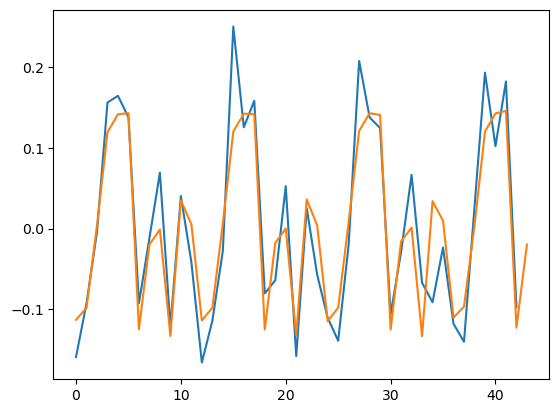

In [24]:
plt.plot(test_df['Change'].values)
plt.plot(pred['yhat'].values[100:])

## Task, try to improve the results above. What values or parameters did you change?

# Matrix Profile
A matrix profile captures the similarity within a time series by computing the distances between subsequences.
The matrix profile provide information about the underlying patterns and anomalies within a time series. 
We will make use of the stumpy library for this: https://github.com/TDAmeritrade/stumpy.

In [25]:
!pip install stumpy

In [26]:
taxi_df = pd.read_csv("https://zenodo.org/record/4276428/files/STUMPY_Basics_Taxi.csv?download=1")
taxi_df['value'] = taxi_df['value'].astype(np.float64)
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df.head()


,timestamp,value
0,2014-10-01 00:00:00,12751.0
1,2014-10-01 00:30:00,8767.0
2,2014-10-01 01:00:00,7005.0
3,2014-10-01 01:30:00,5257.0
4,2014-10-01 02:00:00,4189.0


In [27]:
WEEK = 7 # days 
N = taxi_df.shape[0]
HOURS_A_DAY = 24 
WINDOW = HOURS_A_DAY * 2 # Data is taken every thirty minutes, so there can be 48 entries in one day window 

In [28]:
taxi_df[(taxi_df.timestamp.dt.hour==0)]['timestamp']

0      2014-10-01 00:00:00
1      2014-10-01 00:30:00
48     2014-10-02 00:00:00
49     2014-10-02 00:30:00
96     2014-10-03 00:00:00
               ...        
3457   2014-12-12 00:30:00
3504   2014-12-13 00:00:00
3505   2014-12-13 00:30:00
3552   2014-12-14 00:00:00
3553   2014-12-14 00:30:00
Name: timestamp, Length: 150, dtype: datetime64[ns]

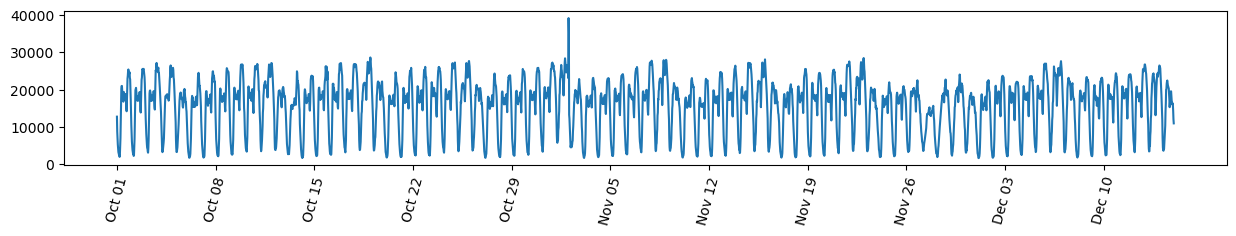

In [29]:
plt.figure(figsize=(15,2))
plt.plot(taxi_df['value'])
x_axis_labels = taxi_df[(taxi_df.timestamp.dt.hour==0)]['timestamp'].dt.strftime('%b %d').values[::14]
plt.xticks(np.arange(0, N, (WINDOW*WEEK)), x_axis_labels);
plt.xticks(rotation=75);
plt.show()


## To obtain a Matrix Profile, we will use stumpy.stump()
This takes in a time series and computes the matrix profile along with the matrix profile indices.

In [30]:
import stumpy
mp = stumpy.stump(taxi_df['value'], m=48) # 1 day window 

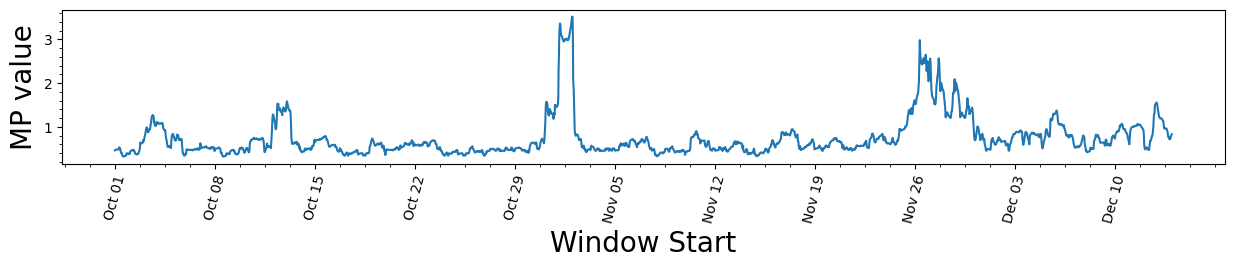

In [31]:
plt.figure(figsize=(15,2))
plt.xlabel('Window Start', fontsize ='20')
plt.ylabel('MP value', fontsize='20')
plt.plot(mp[:, 0])
plt.xticks(np.arange(0, N, (WINDOW*WEEK)), x_axis_labels);
plt.xticks(rotation=75);
plt.minorticks_on()
plt.show()

# Task: Find the motif and discords from the graph above 
Hint: https://stumpy.readthedocs.io/en/latest/api.html#

In [32]:
## Your code here


In [51]:
## Your code here


# Timeseries Transformation

## Piecewise Aggregate Approximation 

In [34]:
!pip install tslearn

In [35]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation

In [36]:
ts = df['#Passengers'].values 

In [37]:
ts = ts.reshape(1, -1)
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1)
ts2 = scaler.fit_transform(ts)
paa = PiecewiseAggregateApproximation(n_segments=44)
paa_out = paa.inverse_transform(paa.fit_transform(ts2))

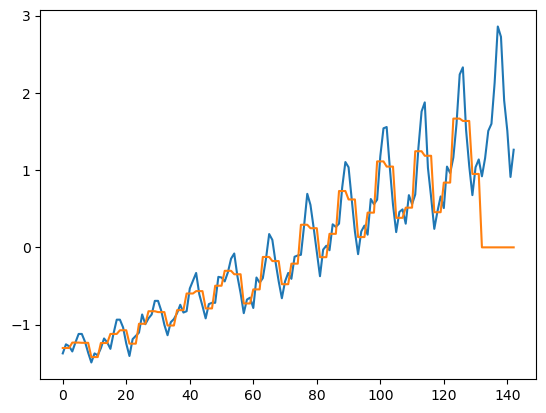

In [38]:
plt.plot(ts2.reshape(-1), label='original')
plt.plot(paa_out.reshape(-1), label='paa')

## Task: Implement Symbolic Aggregate Approximation 

In [39]:
## Your code here

## Time-series Clustering
In timeseries clustering, our aim is to find similarities between the datapoints in our series. This is an important tool when patterns are not visible by visual inspection. Dynamic Time Warping helps us achieves this by measuring the dissimilarity or warping distance between data points in a time series. Unlike Euclidean distance, DTW handles potential temporal shifts,or  stretches between the data points, making it effective in capturing the true similarity between sequences with different temporal behaviors.

## Let's take a look at an example of how this works. We will use a dataset from the tslearn library

In [40]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler

### Take note that tslearn expects the data in the format (samples, timesteps, dims)

In [52]:
n_clusters = 2

X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = TimeSeriesResampler(sz=50).fit_transform(X_train)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True,metric="dtw")
y_pred = model.fit_predict(X_train)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


2.372 --> 1.285 --> 1.285 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


## Next we can visualize the results

<Figure size 1600x900 with 0 Axes>

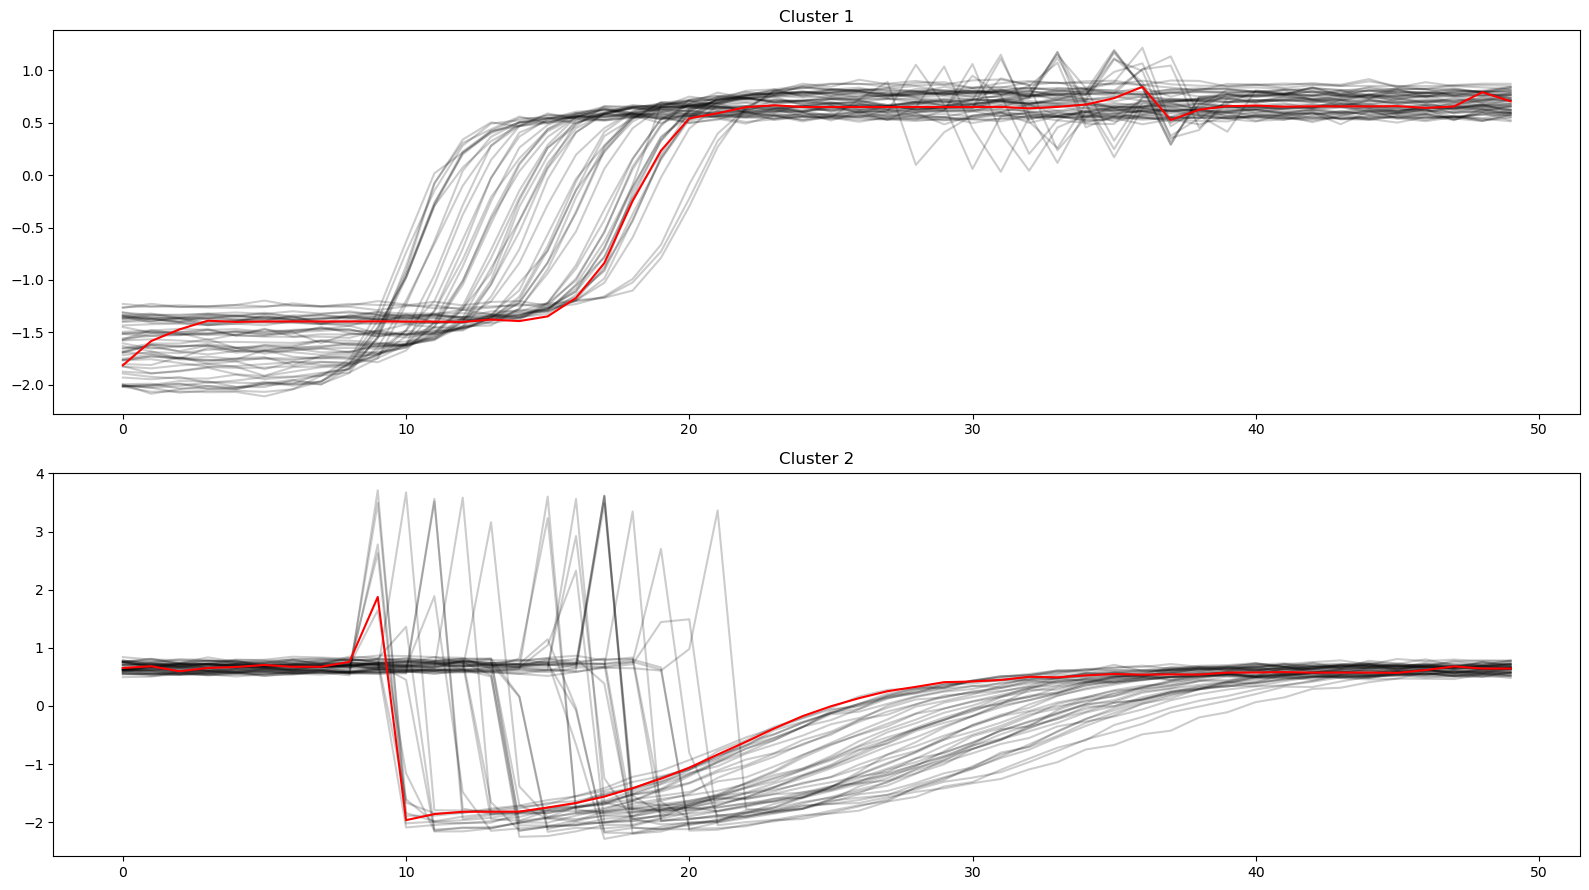

In [53]:

plt.figure(figsize=(16, 9))
plt.figure(figsize=(16, 9))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

## Task: Pick one of the datasets we worked on above and apply timeseries clustering to it. 

In [44]:
## Your code here